In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Participants

In [2]:
folder = './data/'
batch = 'batch-2-20p'
filename = '/BIAT_processed_logs_round-02.csv'

df_participants = pd.read_csv(folder+batch+filename, sep=';')
df_participants = df_participants.set_index('participant_id', drop=True)

# anonymize
df_participants.drop("profession", axis=1, inplace=True)
df_participants.drop("country", axis=1, inplace=True)
df_participants.drop("zipcode", axis=1, inplace=True)
df_participants.drop("email", axis=1, inplace=True)

# filter incomplete/invalid datasets
if(batch=='batch-1-20p'):
    invalid = [
        'undefined_1567130075447', # missing climate change data
        'undefined_1567022177109' # incomplete
    ]
elif(batch=='batch-2-20p'):
    invalid = [
        'undefined_1567784779482',
        'undefined_1567783320446',
        'undefined_1567784038416'
#         'undefined_1567774000263' # missing Progressive/Conservative
    ] 

c = len(df_participants)
df_participants = df_participants.drop(invalid)
print('batch: %s' % batch)
print('%d invalid rows dropped, # of valid participants: %d' % (c-len(df_participants), len(df_participants)))

df_participants.head()

batch: batch-2-20p
3 invalid rows dropped, # of valid participants: 21


,IP,age,gender,pre_study_mode,version,Australian/Multiculturalism_d_score,Australian/Multiculturalism_preferred,Australian/Multiculturalism_magnitude,Australian/Multiculturalism_dScoreFit,Australian/Multiculturalism_self_assessment,...,Man-made Climate Change/Natural Climate Cycles_magnitude,Man-made Climate Change/Natural Climate Cycles_dScoreFit,Man-made Climate Change/Natural Climate Cycles_self_assessment,Man-made Climate Change/Natural Climate Cycles_attributeFocalCategoryFit,Man-made Climate Change/Natural Climate Cycles_focalBlacksheep,Man-made Climate Change/Natural Climate Cycles_focal_wishlist,Man-made Climate Change/Natural Climate Cycles_attributeNonfocalCategoryFit,Man-made Climate Change/Natural Climate Cycles_nonfocal_blacksheep,Man-made Climate Change/Natural Climate Cycles_nonfocal_wishlist,Man-made Climate Change/Natural Climate Cycles_comment
participant_id,,,,,,,,,,,,,,,,,,,,,
undefined_1567842885103,149.28.189.250,32,male,True,2.2,0.313868,Australian,a slight,5.0,2.0,...,little to no,5.0,5.0,4.0,Consumerism,Pollution,6.0,Non-sense,Geography,n.a.
undefined_1567908849630,NaN,19,male,True,2.2,0.637244,Australian,a moderate,6.0,5.0,...,a slight,5.0,5.0,5.0,Consumerism,Pollution,4.0,fearmongering,Nature,NaN
undefined_1567923458305,124.171.110.47,32,female,True,2.2,0.531546,Australian,a moderate,3.0,5.0,...,a strong,3.0,2.0,7.0,NaN,NaN,2.0,NaN,NaN,NaN
undefined_1567800025243,14.201.238.79,20,male,True,2.2,0.599652,Australian,a moderate,2.0,5.0,...,a moderate,4.0,1.0,7.0,n.a.,n.a.,1.0,"Fearmongering, Non-Sense","Time, Sun",NaN
undefined_1567844980419,NaN,16,male,True,2.2,0.200422,Australian,a slight,3.0,5.0,...,little to no,3.0,3.0,5.0,Coal,Climate Change,4.0,Fearmongering,Elnino,n.a


## Demographics

In [3]:
rounded_decimals = 2

print('Total: %d participants' % (len(df_participants)))
# # age
participants_age = [age for age in df_participants['age']]
participants_age = np.asarray(participants_age)
print('Mean age: %f (SD=%f), min: %d, max: %d' % (round(participants_age.mean(), rounded_decimals), round(participants_age.std(), rounded_decimals), participants_age.min(), participants_age.max()))

Total: 21 participants
Mean age: 26.000000 (SD=7.170000), min: 16, max: 38


In [4]:
# gender
df_gender = df_participants.groupby(['gender'])
for index, gender in df_gender:
    print(index, len(gender))

female 7
male 14


# BIAT Analysis
1. (dis)agreement between d_score and self assessment
2. prediction accuracy according to the four classification (d_score/self-assessment agreement (focal and non-focal) and false positives/negatives)
3. and an agreement, disagreement, and co-agreement score (based on Vatavu’s metrics) for term suggestions

Based on 3) we refine the attributes and re-run the study to see whether we can increase 1) and 2)

In [5]:
FOCAL = 0
NON_FOCAL = 1

LIKERT_ASSESSMENT_THRESHOLD = 4 # [1, 7]

# magnitude thresholds
D_SCORE_THRESHOLD_SLIGHT = 0.15   # [.15, .35], little to no < .15
D_SCORE_THRESHOLD_MODERATE = 0.35 # [.35, .65]
D_SCORE_THRESHOLD_STRONG = 0.65   # >.65

def get_preference(d_score, categories=['focal', 'non_focal']):
    if (d_score >= 0.0):
        return categories[FOCAL]
    else:
        return categories[NON_FOCAL]
    
# correlation magnitudes
def get_correlation_magnitude(rvalue):
    if(rvalue >=0):
        resultString = 'a positive'
    elif(rvalue):
        resultString = 'a negative'
    else:
        resultString = 'no'

    rvalue = abs(rvalue)
    if(rvalue < .2):
        resultString += ' weak'
    elif(rvalue < .4):
        resultString += ' moderate'
    else:
        resultString += ' strong'
    
    return resultString + ' correlation'

def calculate_accuracy(tp, tn, fp, fn):
    return (tp+tn)/(tp+fp+fn+tn)

## Progressive/Conservative
### d-Score Fit

1 row(s) dropped, total dataset 'Progressive/Conservative': 20
Mean Progressive/Conservative_dScoreFit: 5.100000 (SD=1.590000), median: 5, min: 1, max: 7


[(1, 7)]

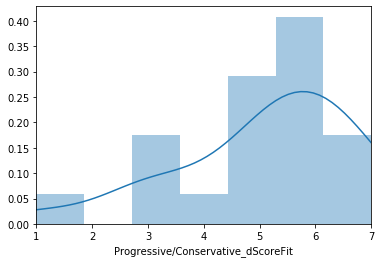

In [6]:
biat = 'Progressive/Conservative'
categories = biat.split('/') # [focal non_focal]

col = biat + '_dScoreFit'
d_score_fit = df_participants[col]

# remove NaNs
c = len(d_score_fit)
d_score_fit = d_score_fit.dropna()
print('%d row(s) dropped, total dataset \'%s\': %d' % (c-len(d_score_fit), biat, len(d_score_fit)))
print('Mean %s: %f (SD=%f), median: %d, min: %d, max: %d' % (col, round(d_score_fit.mean(), rounded_decimals), round(d_score_fit.std(), rounded_decimals), np.median(d_score_fit), d_score_fit.min(), d_score_fit.max()))

figure = sns.distplot(d_score_fit);
figure.set(xlim=(1, 7))

## Correlation: d_score vs. self-assessment

In [7]:
d_scores = df_participants[[biat+'_d_score', biat+'_self_assessment']]
d_scores = d_scores.dropna()
d_scores

,Progressive/Conservative_d_score,Progressive/Conservative_self_assessment
participant_id,,
undefined_1567842885103,0.014451,6.0
undefined_1567908849630,-0.243089,6.0
undefined_1567923458305,0.517845,2.0
undefined_1567800025243,0.723926,1.0
undefined_1567844980419,0.342496,3.0
undefined_1567875904402,-0.840992,6.0
undefined_1567826920627,0.381107,1.0
undefined_1567803390992,0.371299,3.0
undefined_1567918609602,0.348152,5.0


Pearson correlation: -0.386503, a negative moderate correlation (p=0.092308)


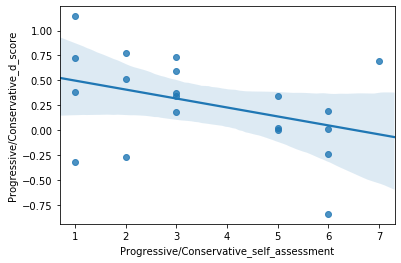

In [8]:
corr, pvalue = pearsonr(d_scores[biat+'_d_score'], d_scores[biat+'_self_assessment'])
# corr = d_scores.corr(method='pearson')
# corr

sns.regplot(y=biat+'_d_score', x=biat+'_self_assessment', data=d_scores);
print('Pearson correlation: %f, %s (p=%f)' % (corr, get_correlation_magnitude(corr),pvalue))

## Focal vs. Non-focal
Four classes (d_score, self_assessment):
- **true focals** (0, 0): participants agreeing with being classified with a focal preference, e.g., a true progressive
- **false focals** (0, 1): participants disagreeing with being classified with a focal preference, e.g., a conservative progressive
- **true non_focals** (1, 1): participants agreeing with being classified with a non_focal preference, e.g., a true conservative
- **false non_focals** (1, 0): participants disagreeing with being classified with a non_focal preference, e.g., a progressive conservative

10 true focals
5 false focals
2 true non_focals
2 false non_focals


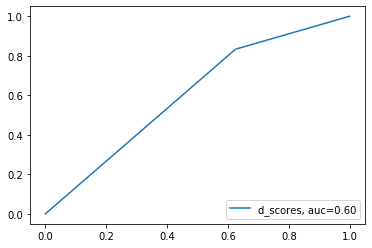


accuracy: 0.65, precision: 0.65 recall: 0.65, f1: 0.65


In [9]:
true_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
false_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
true_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
false_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
print('%d true focals' % (len(true_focals)))
print('%d false focals' % (len(false_focals)))
print('%d true non_focals' % (len(true_non_focals)))
print('%d false non_focals' % (len(false_non_focals)))

d_scores_focal = [(row[1][biat + '_d_score'] > 0) for row in d_scores.iterrows()]
self_assessments_focal = [(row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD) for row in d_scores.iterrows()]

accuracy = accuracy_score(self_assessments_focal, d_scores_focal)
precision = precision_score(self_assessments_focal, d_scores_focal)
recall = recall_score(self_assessments_focal, d_scores_focal)
f1 = f1_score(self_assessments_focal, d_scores_focal)

fpr, tpr, _ = roc_curve(self_assessments_focal,  d_scores_focal)
auc = roc_auc_score(self_assessments_focal, d_scores_focal)
plt.plot(fpr,tpr,label='d_scores, auc={0:0.2f}'.format(auc))
plt.legend(loc=4)
plt.show()

print('')
print('accuracy: {0:0.2f}, precision: {0:0.2f} recall: {0:0.2f}, f1: {0:0.2f}'.format(accuracy, precision, recall, f1))

## Feminism/Anti-feminism
### d-Score Fit

0 row(s) dropped, total dataset 'Feminism/Anti-feminism': 21
Mean Feminism/Anti-feminism_dScoreFit: 5.240000 (SD=1.760000), median: 6, min: 1, max: 7


[(1, 7)]

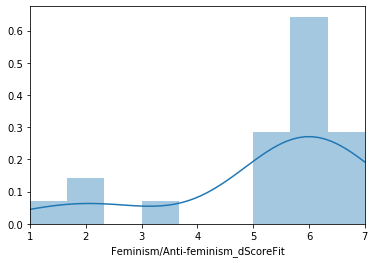

In [10]:
biat = 'Feminism/Anti-feminism'
categories = biat.split('/') # [focal non_focal]

col = biat + '_dScoreFit'
d_score_fit = df_participants[col]

# remove NaNs
c = len(d_score_fit)
d_score_fit = d_score_fit.dropna()
print('%d row(s) dropped, total dataset \'%s\': %d' % (c-len(d_score_fit), biat, len(d_score_fit)))
print('Mean %s: %f (SD=%f), median: %d, min: %d, max: %d' % (col, round(d_score_fit.mean(), rounded_decimals), round(d_score_fit.std(), rounded_decimals), np.median(d_score_fit), d_score_fit.min(), d_score_fit.max()))

figure = sns.distplot(d_score_fit);
figure.set(xlim=(1, 7))

## Correlation: d_score vs. self-assessment

In [11]:
d_scores = df_participants[[biat+'_d_score', biat+'_self_assessment']]
d_scores = d_scores.dropna()
d_scores

,Feminism/Anti-feminism_d_score,Feminism/Anti-feminism_self_assessment
participant_id,,
undefined_1567842885103,0.766102,6.0
undefined_1567908849630,0.107527,7.0
undefined_1567923458305,1.191966,1.0
undefined_1567800025243,0.882312,2.0
undefined_1567844980419,-0.131087,3.0
undefined_1567875904402,0.245786,6.0
undefined_1567826920627,0.550207,3.0
undefined_1567803390992,0.732592,3.0
undefined_1567918609602,-0.019986,3.0


Pearson correlation: -0.216129, a negative moderate correlation (p=0.346721)


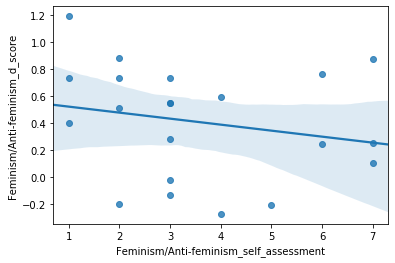

In [12]:
corr, pvalue = pearsonr(d_scores[biat+'_d_score'], d_scores[biat+'_self_assessment'])
# corr = d_scores.corr(method='pearson')
# corr

sns.regplot(y=biat+'_d_score', x=biat+'_self_assessment', data=d_scores);
print('Pearson correlation: %f, %s (p=%f)' % (corr, get_correlation_magnitude(corr),pvalue))

## Focal vs. Non-focal
Four classes (d_score, self_assessment):
- **true focals** (0, 0): participants agreeing with being classified with a focal preference, e.g., a true progressive
- **false focals** (0, 1): participants disagreeing with being classified with a focal preference, e.g., a conservative progressive
- **true non_focals** (1, 1): participants agreeing with being classified with a non_focal preference, e.g., a true conservative
- **false non_focals** (1, 0): participants disagreeing with being classified with a non_focal preference, e.g., a progressive conservative

10 true focals
5 false focals
1 true non_focals
3 false non_focals


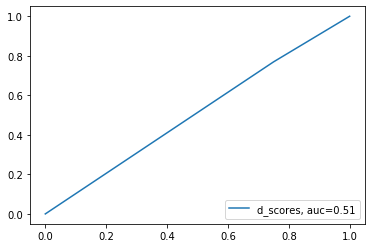


accuracy: 0.57, precision: 0.57 recall: 0.57, f1: 0.57


In [13]:
true_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
false_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
true_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
false_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
print('%d true focals' % (len(true_focals)))
print('%d false focals' % (len(false_focals)))
print('%d true non_focals' % (len(true_non_focals)))
print('%d false non_focals' % (len(false_non_focals)))

d_scores_focal = [(row[1][biat + '_d_score'] > 0) for row in d_scores.iterrows()]
self_assessments_focal = [(row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD) for row in d_scores.iterrows()]

accuracy = accuracy_score(self_assessments_focal, d_scores_focal)
precision = precision_score(self_assessments_focal, d_scores_focal)
recall = recall_score(self_assessments_focal, d_scores_focal)
f1 = f1_score(self_assessments_focal, d_scores_focal)

fpr, tpr, _ = roc_curve(self_assessments_focal,  d_scores_focal)
auc = roc_auc_score(self_assessments_focal, d_scores_focal)
plt.plot(fpr,tpr,label='d_scores, auc={0:0.2f}'.format(auc))
plt.legend(loc=4)
plt.show()

print('')
print('accuracy: {0:0.2f}, precision: {0:0.2f} recall: {0:0.2f}, f1: {0:0.2f}'.format(accuracy, precision, recall, f1))

## Australian/Multiculturalism
### d-Score Fit

0 row(s) dropped, total dataset 'Australian/Multiculturalism': 21
Mean Australian/Multiculturalism_dScoreFit: 4.900000 (SD=1.870000), median: 6, min: 1, max: 7


[(1, 7)]

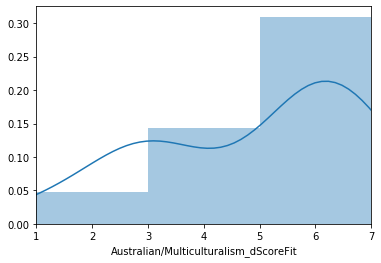

In [14]:
biat = 'Australian/Multiculturalism'
categories = biat.split('/') # [focal non_focal]

col = biat + '_dScoreFit'
d_score_fit = df_participants[col]

# remove NaNs
c = len(d_score_fit)
d_score_fit = d_score_fit.dropna()
print('%d row(s) dropped, total dataset \'%s\': %d' % (c-len(d_score_fit), biat, len(d_score_fit)))
print('Mean %s: %f (SD=%f), median: %d, min: %d, max: %d' % (col, round(d_score_fit.mean(), rounded_decimals), round(d_score_fit.std(), rounded_decimals), np.median(d_score_fit), d_score_fit.min(), d_score_fit.max()))

figure = sns.distplot(d_score_fit);
figure.set(xlim=(1, 7))

## Correlation: d_score vs. self-assessment

In [15]:
d_scores = df_participants[[biat+'_d_score', biat+'_self_assessment']]
d_scores = d_scores.dropna()
d_scores

,Australian/Multiculturalism_d_score,Australian/Multiculturalism_self_assessment
participant_id,,
undefined_1567842885103,0.313868,2.0
undefined_1567908849630,0.637244,5.0
undefined_1567923458305,0.531546,5.0
undefined_1567800025243,0.599652,5.0
undefined_1567844980419,0.200422,5.0
undefined_1567875904402,0.177357,6.0
undefined_1567826920627,1.161340,1.0
undefined_1567803390992,-0.367443,4.0
undefined_1567918609602,0.158902,6.0


Pearson correlation: -0.524944, a negative strong correlation (p=0.014549)


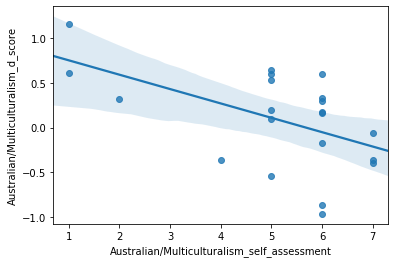

In [16]:
corr, pvalue = pearsonr(d_scores[biat+'_d_score'], d_scores[biat+'_self_assessment'])
# corr = d_scores.corr(method='pearson')
# corr

sns.regplot(y=biat+'_d_score', x=biat+'_self_assessment', data=d_scores);
print('Pearson correlation: %f, %s (p=%f)' % (corr, get_correlation_magnitude(corr),pvalue))

## Focal vs. Non-focal
Four classes (d_score, self_assessment):
- **true focals** (0, 0): participants agreeing with being classified with a focal preference, e.g., a true progressive
- **false focals** (0, 1): participants disagreeing with being classified with a focal preference, e.g., a conservative progressive
- **true non_focals** (1, 1): participants agreeing with being classified with a non_focal preference, e.g., a true conservative
- **false non_focals** (1, 0): participants disagreeing with being classified with a non_focal preference, e.g., a progressive conservative

3 true focals
10 false focals
7 true non_focals
0 false non_focals


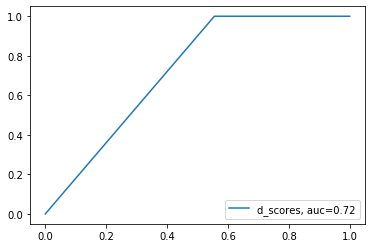


accuracy: 0.52, precision: 0.52 recall: 0.52, f1: 0.52


In [17]:
true_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
false_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
true_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
false_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
print('%d true focals' % (len(true_focals)))
print('%d false focals' % (len(false_focals)))
print('%d true non_focals' % (len(true_non_focals)))
print('%d false non_focals' % (len(false_non_focals)))

d_scores_focal = [(row[1][biat + '_d_score'] > 0) for row in d_scores.iterrows()]
self_assessments_focal = [(row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD) for row in d_scores.iterrows()]

accuracy = accuracy_score(self_assessments_focal, d_scores_focal)
precision = precision_score(self_assessments_focal, d_scores_focal)
recall = recall_score(self_assessments_focal, d_scores_focal)
f1 = f1_score(self_assessments_focal, d_scores_focal)

fpr, tpr, _ = roc_curve(self_assessments_focal,  d_scores_focal)
auc = roc_auc_score(self_assessments_focal, d_scores_focal)
plt.plot(fpr,tpr,label='d_scores, auc={0:0.2f}'.format(auc))
plt.legend(loc=4)
plt.show()

print('')
print('accuracy: {0:0.2f}, precision: {0:0.2f} recall: {0:0.2f}, f1: {0:0.2f}'.format(accuracy, precision, recall, f1))

## Man-made Climate Change/Natural Climate Cycles
### d-Score Fit

2 row(s) dropped, total dataset 'Man-made Climate Change/Natural Climate Cycles': 19
Mean Man-made Climate Change/Natural Climate Cycles_dScoreFit: 4.470000 (SD=1.680000), median: 5, min: 1, max: 7


[(1, 7)]

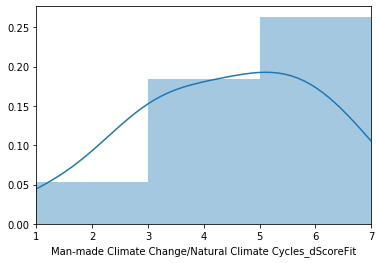

In [18]:
biat = 'Man-made Climate Change/Natural Climate Cycles'
categories = biat.split('/') # [focal non_focal]

col = biat + '_dScoreFit'
d_score_fit = df_participants[col]

# remove NaNs
c = len(d_score_fit)
d_score_fit = d_score_fit.dropna()
print('%d row(s) dropped, total dataset \'%s\': %d' % (c-len(d_score_fit), biat, len(d_score_fit)))
print('Mean %s: %f (SD=%f), median: %d, min: %d, max: %d' % (col, round(d_score_fit.mean(), rounded_decimals), round(d_score_fit.std(), rounded_decimals), np.median(d_score_fit), d_score_fit.min(), d_score_fit.max()))

figure = sns.distplot(d_score_fit);
figure.set(xlim=(1, 7))

## Correlation: d_score vs. self-assessment

In [19]:
d_scores = df_participants[[biat+'_d_score', biat+'_self_assessment']]
d_scores = d_scores.dropna()
d_scores

,Man-made Climate Change/Natural Climate Cycles_d_score,Man-made Climate Change/Natural Climate Cycles_self_assessment
participant_id,,
undefined_1567842885103,-0.083486,5.0
undefined_1567908849630,0.306522,5.0
undefined_1567923458305,-0.906250,2.0
undefined_1567800025243,0.467521,1.0
undefined_1567844980419,-0.127080,3.0
undefined_1567826920627,-0.859153,2.0
undefined_1567803390992,-0.247482,5.0
undefined_1567918609602,-0.206282,4.0
undefined_1567811856060,-0.695603,4.0


Pearson correlation: -0.185969, a negative weak correlation (p=0.445897)


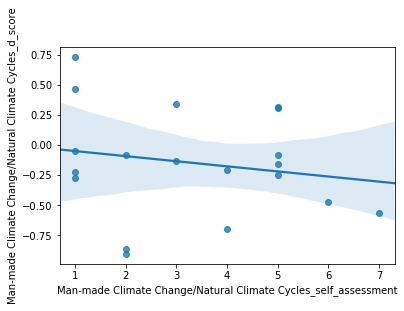

In [20]:
corr, pvalue = pearsonr(d_scores[biat+'_d_score'], d_scores[biat+'_self_assessment'])
# corr = d_scores.corr(method='pearson')
# corr

sns.regplot(y=biat+'_d_score', x=biat+'_self_assessment', data=d_scores);
print('Pearson correlation: %f, %s (p=%f)' % (corr, get_correlation_magnitude(corr),pvalue))

## Focal vs. Non-focal
Four classes (d_score, self_assessment):
- **true focals** (0, 0): participants agreeing with being classified with a focal preference, e.g., a true progressive
- **false focals** (0, 1): participants disagreeing with being classified with a focal preference, e.g., a conservative progressive
- **true non_focals** (1, 1): participants agreeing with being classified with a non_focal preference, e.g., a true conservative
- **false non_focals** (1, 0): participants disagreeing with being classified with a non_focal preference, e.g., a progressive conservative

3 true focals
2 false focals
5 true non_focals
7 false non_focals


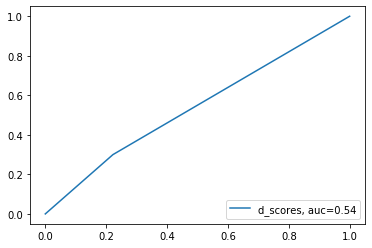


accuracy: 0.53, precision: 0.53 recall: 0.53, f1: 0.53


In [21]:
true_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
false_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
true_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
false_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
print('%d true focals' % (len(true_focals)))
print('%d false focals' % (len(false_focals)))
print('%d true non_focals' % (len(true_non_focals)))
print('%d false non_focals' % (len(false_non_focals)))

d_scores_focal = [(row[1][biat + '_d_score'] > 0) for row in d_scores.iterrows()]
self_assessments_focal = [(row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD) for row in d_scores.iterrows()]

accuracy = accuracy_score(self_assessments_focal, d_scores_focal)
precision = precision_score(self_assessments_focal, d_scores_focal)
recall = recall_score(self_assessments_focal, d_scores_focal)
f1 = f1_score(self_assessments_focal, d_scores_focal)

fpr, tpr, _ = roc_curve(self_assessments_focal,  d_scores_focal)
auc = roc_auc_score(self_assessments_focal, d_scores_focal)
plt.plot(fpr,tpr,label='d_scores, auc={0:0.2f}'.format(auc))
plt.legend(loc=4)
plt.show()

print('')
print('accuracy: {0:0.2f}, precision: {0:0.2f} recall: {0:0.2f}, f1: {0:0.2f}'.format(accuracy, precision, recall, f1))